In [1]:
import numpy as np

import keras
from keras import Sequential, optimizers
from keras.layers import Dense, Activation,BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import np_utils
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = 72

Using TensorFlow backend.


In [0]:
#Define functions
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]



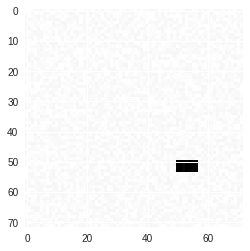

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')



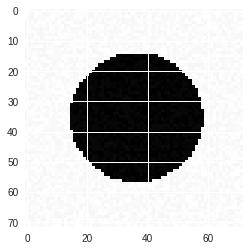

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')



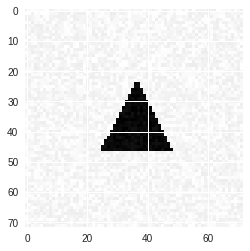

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In [0]:
from tqdm import tqdm
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in tqdm(range(nb_samples)):

        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in tqdm(range(nb_samples)):

        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


# Question 3 simple classification

In [8]:
#generate train dataset and test dataset
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_test_set_classification()
Y_train = to_categorical(Y_train)


  1%|          | 3/300 [00:00<00:10, 29.64it/s]

Creating data:


  1%|▏         | 4/300 [00:00<00:09, 32.66it/s]

Creating data:


100%|██████████| 300/300 [00:10<00:00, 28.71it/s]


In [9]:

#check the size of each dataset
print(Y_train.shape)
print(X_train.shape)
print(Y_test.shape)
print(X_test.shape)


(300, 3)
(300, 5184)
(300, 3)
(300, 5184)


In [0]:
#create model and add layers
model = Sequential()

model.add(Dense(1024,input_shape=(5184,),activation = 'tanh'))
model.add(Dense(512,activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))


## Optimizer: SGD

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd,metrics=['accuracy'])

In [27]:
#fit and evaluate the model
model.fit(X_train,Y_train,epochs=5,batch_size=32,validation_split=0.3)
model.evaluate(X_test,Y_test)

Train on 210 samples, validate on 90 samples
Epoch 1/5
210/210 [==============================] - 1s 6ms/step - loss: 0.2494 - acc: 0.4381 - val_loss: 0.1667 - val_acc: 0.6556
Epoch 2/5
210/210 [==============================] - 1s 3ms/step - loss: 0.2101 - acc: 0.5095 - val_loss: 0.1196 - val_acc: 0.8333
Epoch 3/5
210/210 [==============================] - 1s 3ms/step - loss: 0.1369 - acc: 0.7095 - val_loss: 0.0960 - val_acc: 0.8222
Epoch 4/5
210/210 [==============================] - 1s 3ms/step - loss: 0.1044 - acc: 0.7667 - val_loss: 0.1811 - val_acc: 0.6444
Epoch 5/5
300/300 [==============================] - 0s 539us/step


[0.1222070488333702, 0.703333334128062]

## Adam

In [29]:
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])
model.evaluate(X_test,Y_test)

300/300 [==============================] - 0s 1ms/step


[0.5597379124164581, 0.703333334128062]

In [30]:
# test model
X_test1 = generate_a_rectangle()
X_test1 = X_test1.reshape(1, X_test1.shape[0]) 
model.predict(X_test1)

array([[0.5536116 , 0.4391753 , 0.00721317]], dtype=float32)

# Question 4 visualization

In [0]:
weights=model.get_weights()

In [32]:
weights

[array([[-0.00593339, -0.02404642, -0.0271825 , ..., -0.01251108,
         -0.00532112,  0.01960999],
        [ 0.01309808, -0.02561786, -0.00771456, ..., -0.01599117,
          0.01759647,  0.02094884],
        [-0.025571  , -0.00914736,  0.03076158, ..., -0.01537106,
         -0.02371987, -0.00087535],
        ...,
        [-0.00225019, -0.02859714,  0.02992795, ...,  0.01168217,
         -0.00271015,  0.02597287],
        [-0.0041812 ,  0.01204968, -0.01144296, ...,  0.01068668,
          0.01547542, -0.02345286],
        [-0.02214336, -0.00804606,  0.01122567, ...,  0.01897936,
          0.03005438,  0.01933245]], dtype=float32),
 array([-3.54277399e-05,  1.03060365e-05, -2.48540950e-04, ...,
        -3.26101763e-05, -1.11252375e-04,  1.18126132e-04], dtype=float32),
 array([[ 0.0493926 ,  0.04659777, -0.06024993, ...,  0.0122195 ,
         -0.0244862 , -0.03905794],
        [ 0.02044544,  0.04790405,  0.02762881, ...,  0.02390409,
         -0.03027618,  0.02879162],
        [ 0.02

In [33]:
weights=model.get_weights()
for i in weights:
    print(i.shape)

(5184, 1024)
(1024,)
(1024, 512)
(512,)
(512, 512)
(512,)
(512, 256)
(256,)
(256, 3)
(3,)


In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

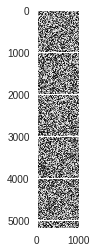

In [40]:
plt.imshow(weights[0], cmap='gray')

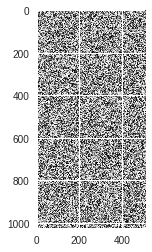

In [41]:
plt.imshow(weights[2], cmap = cm.Greys)

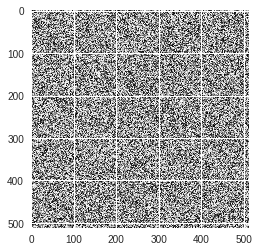

In [43]:
plt.imshow(weights[4], cmap = cm.Greys)

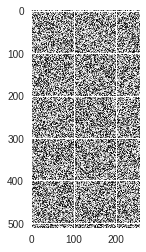

In [44]:
plt.imshow(weights[6], cmap = cm.Greys)

# Question 5 a more difficult classification problem

In [45]:
#generate data
[X_train2, Y_train2] = generate_dataset_classification(300, 20, True)
[X_test2, Y_test2] = generate_test_set_classification()


Y_train2 = to_categorical(Y_train2)

  1%|          | 3/300 [00:00<00:10, 29.10it/s]

Creating data:


  1%|▏         | 4/300 [00:00<00:09, 31.79it/s]

Creating data:


100%|██████████| 300/300 [00:10<00:00, 27.75it/s]


In [0]:
#reshape the dataset
X_train2 = X_train2.reshape(X_train2.shape[0], 72,72,1)
X_train2 = X_train2.astype('float32')
X_test2=X_test2.reshape(X_test2.shape[0], 72,72,1)
X_test2 = X_test2.astype('float32')

In [47]:
#check the size of each dataset
print(Y_train2.shape)
print(X_train2.shape)
print(Y_test2.shape)
print(X_test2.shape)


(300, 3)
(300, 72, 72, 1)
(300, 3)
(300, 72, 72, 1)


In [0]:
#create the model and add layers
conv_model = Sequential()
conv_model.add(Conv2D(16, kernel_size=5, activation = 'relu'))
conv_model.add(MaxPooling2D(pool_size=2,strides=2,padding='same'))
conv_model.add(Flatten())
conv_model.add(Dense(1280 ,activation = 'relu'))

conv_model.add(Dense(3,activation = 'sigmoid'))

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
conv_model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])



In [52]:
#fit model
conv_model.fit(X_train2, Y_train2, epochs=5, batch_size=32)


Epoch 1/5
300/300 [==============================] - 5s 15ms/step - loss: 0.2263 - acc: 0.3533
Epoch 2/5
300/300 [==============================] - 4s 12ms/step - loss: 0.2104 - acc: 0.4300
Epoch 3/5
300/300 [==============================] - 4s 12ms/step - loss: 0.2044 - acc: 0.5333
Epoch 4/5
300/300 [==============================] - 4s 12ms/step - loss: 0.2015 - acc: 0.4900
Epoch 5/5
300/300 [==============================] - 4s 12ms/step - loss: 0.1877 - acc: 0.5400


In [53]:
#evaluate the model
conv_model.evaluate(X_test2, Y_test2)


300/300 [==============================] - 1s 3ms/step


[0.24874796330928803, 0.31333333333333335]

# Question 6 Regression 

In [0]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


  1%|▏         | 4/300 [00:00<00:08, 33.11it/s]

Creating data:


100%|██████████| 300/300 [00:11<00:00, 26.86it/s]


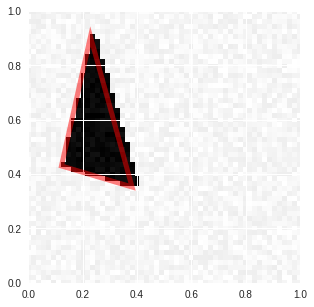

  1%|▏         | 4/300 [00:00<00:09, 31.34it/s]

Creating data:


100%|██████████| 300/300 [00:10<00:00, 27.52it/s]


In [55]:
[X_train3, Y_train3] = generate_dataset_regression(300, 20)
visualize_prediction(X_train3[0], Y_train3[0])
[X_test3, Y_test3] = generate_test_set_regression()

In [66]:
import tensorflow as tf
#normailze data

Y_train3_norm = (Y_train3 - Y_train3.mean()) / Y_train3.std()
Y_train3_norm

Y_test3_norm = (Y_test3 - Y_test3.mean()) / Y_train3.std()
Y_test3_norm

array([[ 1.52516737,  1.51433792,  0.61601987, -0.76135221, -0.45968332,
        -0.56694481],
       [-0.01287871,  1.08790622, -1.09506885,  0.96029584,  0.05432948,
         1.00055208],
       [-0.90667056, -1.17832653,  0.06089944, -0.15137804, -0.60247384,
         1.29359482],
       ...,
       [ 1.39131635, -1.42932665, -1.49512775,  1.40249049, -0.64174601,
        -0.16422125],
       [-1.60545087,  0.91859475, -1.08033477, -1.31610008, -0.4635766 ,
        -0.68574181],
       [-0.207337  ,  1.53889061, -0.01228004, -1.27646093, -0.19989781,
         1.69359794]])

In [67]:
Y_train3_norm

array([[-0.40520832, -0.50765561, -0.93067912,  1.39276188, -1.29763652,
        -0.24102419],
       [-0.23013318,  1.66168917, -0.19007014,  0.19212843,  1.02904667,
        -1.01401948],
       [ 0.37147485,  0.89083547, -0.54911658, -1.68112551, -0.04078187,
        -0.69514778],
       ...,
       [ 0.9722846 ,  0.74672494,  1.03070124, -1.68905801, -0.13571792,
         0.40037901],
       [-0.85480126, -1.33843702,  0.6656852 ,  0.07498714, -0.76762251,
        -1.06377929],
       [-1.48419491, -0.84446517,  1.16137222,  1.4491268 ,  0.51849137,
        -0.86133207]])

In [68]:
Y_test3_norm

array([[ 1.52516737,  1.51433792,  0.61601987, -0.76135221, -0.45968332,
        -0.56694481],
       [-0.01287871,  1.08790622, -1.09506885,  0.96029584,  0.05432948,
         1.00055208],
       [-0.90667056, -1.17832653,  0.06089944, -0.15137804, -0.60247384,
         1.29359482],
       ...,
       [ 1.39131635, -1.42932665, -1.49512775,  1.40249049, -0.64174601,
        -0.16422125],
       [-1.60545087,  0.91859475, -1.08033477, -1.31610008, -0.4635766 ,
        -0.68574181],
       [-0.207337  ,  1.53889061, -0.01228004, -1.27646093, -0.19989781,
         1.69359794]])

In [69]:
print(Y_train3_norm.shape)
print(X_train3.shape)
print(Y_test3_norm.shape)
print(X_test3.shape)

print(Y_train3.shape)
print(Y_test3.shape)

(300, 6)
(300, 5184)
(300, 6)
(300, 5184)
(300, 6)
(300, 6)


In [0]:
# define regression model
def regression_model():
    #create model
    model = Sequential()
#     #add model layers
#     model.add(Convolution2D(16, kernel_size=5, activation='relu'))
#     model.add(MaxPooling2D(pool_size=2,strides=2,padding='same'))
    model.add(Dropout(0.55))
#     model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.2))
#     model.add(Dense(1280, activation='softmax'))
    model.add(Dense(6))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model

In [75]:
# build the model
reg_model = regression_model()

# fit the model
reg_model.fit(X_train3, Y_train3_norm, epochs=15, batch_size=32)

score = reg_model.evaluate(X_test3, Y_test3_norm)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/15
300/300 [==============================] - 2s 5ms/step - loss: 1.6011 - acc: 0.1400
Epoch 2/15
300/300 [==============================] - 1s 2ms/step - loss: 1.3201 - acc: 0.1500
Epoch 3/15
300/300 [==============================] - 1s 2ms/step - loss: 1.3259 - acc: 0.1567
Epoch 4/15
300/300 [==============================] - 1s 2ms/step - loss: 1.3460 - acc: 0.1300
Epoch 5/15
300/300 [==============================] - 1s 2ms/step - loss: 1.3054 - acc: 0.1400
Epoch 6/15
300/300 [==============================] - 1s 2ms/step - loss: 1.2776 - acc: 0.1667
Epoch 7/15
300/300 [==============================] - 1s 2ms/step - loss: 1.2136 - acc: 0.1633
Epoch 8/15
300/300 [==============================] - 1s 2ms/step - loss: 1.2170 - acc: 0.1667
Epoch 9/15
300/300 [==============================] - 1s 2ms/step - loss: 1.2172 - acc: 0.1600
Epoch 10/15
300/300 [==============================] - 1s 2ms/step - loss: 1.1700 - acc: 0.1333
Epoch 11/15
300/300 [============================

# Question 7 image denoising

In [0]:
from tqdm import tqdm
def generate_dataset_classification2(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    M = np.zeros([nb_samples,im_size])
    N = np.zeros(nb_samples)
    
    print('Creating data:')
    for i in tqdm(range(nb_samples)):

        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
            M[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
            M[i] = generate_a_disk(0, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
            [M[i], V] = generate_a_triangle(0, free_location)
        Y[i] = category
        N[i] = category
    X = (X + noise) / (255 + 2 * noise)
    M = (X + 0) / (255 + 2 * 0)
    return [X,Y],[M,N]



In [77]:
[X, Y],[M,N] = generate_dataset_classification2(nb_samples=300, noise=20, free_location=False)


  1%|          | 2/300 [00:00<00:20, 14.70it/s]

Creating data:


100%|██████████| 300/300 [00:21<00:00, 15.38it/s]


In [0]:
#create model and add layers
model4 = Sequential()

model4.add(Dense(1024,input_shape=(5184,),activation = 'tanh'))
model4.add(Dense(512,activation = 'tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(512,activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(256,activation='tanh'))
model4.add(Dropout(0.2))
model4.add(Dense(1,activation='softmax'))


In [0]:
from keras import Sequential, optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(loss='mean_squared_error', optimizer=sgd,metrics=['accuracy'])

In [80]:
#fit and evaluate the model
model4.fit(X,Y,epochs=5,batch_size=32,validation_split=0.3)
model4.evaluate(M,N)

Train on 210 samples, validate on 90 samples
Epoch 1/5
210/210 [==============================] - 2s 8ms/step - loss: 0.6286 - acc: 0.3714 - val_loss: 0.6556 - val_acc: 0.3444
Epoch 2/5
210/210 [==============================] - 1s 3ms/step - loss: 0.6286 - acc: 0.3714 - val_loss: 0.6556 - val_acc: 0.3444
Epoch 3/5
210/210 [==============================] - 1s 3ms/step - loss: 0.6286 - acc: 0.3714 - val_loss: 0.6556 - val_acc: 0.3444
Epoch 4/5
210/210 [==============================] - 1s 3ms/step - loss: 0.6286 - acc: 0.3714 - val_loss: 0.6556 - val_acc: 0.3444
Epoch 5/5
300/300 [==============================] - 0s 577us/step


[0.6366666662693024, 0.3633333325386047]